## Tutorial for SpaDiff 

SpaDiff is a denoising method for sequencing-based spatial transcriptomics data. Sequencing platforms such as 10x Genomics Visium often suffer from spot-swapping, where RNA molecules diffuse into neighboring spots and blur spatial resolution. SpaDiff models this effect as a diffusion process and then applies a reverse diffusion step to correct it. This restores the original spatial distribution of transcripts while preserving UMI counts, leading to clearer spatial patterns and more accurate downstream analyses such as clustering and domain detection.

### 1. Load package

We begin by importing the necessary Python packages and the SpaDiff module:

In [1]:
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy.io import mmwrite
from scipy.sparse import csr_matrix
import scipy.sparse as sp
import gzip
import os

from SpaDiff import *

$\cdot$ pandas / numpy: for handling matrices and data frames.

$\cdot$ scipy.io / scipy.sparse: to read and write the gene expression matrices in sparse format (common in spatial transcriptomics).

$\cdot$ gzip / os: for working with compressed files and file paths.

$\cdot$ SpaDiff: the main package implementing the denoising method.

### 2. Load Data 

Here we use the SpatialLIBD dataset (DLPFC, 10x Visium platform). Each tissue section contains:

$\cdot$ barcodes: identifiers for Visium capture spots.

$\cdot$ genes: list of measured genes.

$\cdot$ count matrix: raw expression counts (UMIs per spot × gene).

$\cdot$ spatial coordinates: spot positions on the tissue slide.

$\cdot$ meta data (optional): annotation information (e.g., tissue region, cortical layer).

In [ ]:
tissue = '151676'
file_path = '/direction/to/the/data/' + tissue

# --- Load barcode (spot) identifiers ---
data_barcodes = pd.read_csv(file_path + '/barcodes.csv', header=0)
data_barcodes.columns = ['barcodes']

# --- Load gene names ---
# Usually provided in "features.csv" or "genes.csv" file
data_features = pd.read_csv(file_path + '/genes.csv', header=None)
data_features.columns = ['genes']

# --- Load raw count matrix (spots × genes) ---
# Stored in sparse format (Matrix Market .mtx file)
data_matrix = csr_matrix(mmread(file_path + '/count_matrix.mtx'))

# --- Load spatial coordinates (spot positions on the slide) ---
data_spatial = pd.read_csv(file_path + '/meta_data.csv')
data_spatial.index = data_spatial['barcode']
# Keep only row/col info and rename as x, y coordinates
data_spatial = data_spatial[['row', 'col']]
data_spatial.columns = ['x', 'y']

# --- Load additional meta data (annotations) ---
# Includes tissue region and manually annotated cortical layers
data_meta = pd.read_csv(file_path + '/meta_data.csv')
data_meta.index = data_meta['barcode']
data_meta = data_meta[['tissue', 'layer_guess']]

### 3. Gene Filtering (Optional)

This step is optional. We apply filtering because very lowly expressed genes and extremely high-expression genes usually do not exhibit clear spatial patterns. Removing them helps focus on genes with stronger spatial signals for denoising.

In [3]:
# --- (Optional) Filter out lowly/highly expressed genes ---
# Compute total counts (UMIs) per gene
row_sums = data_matrix.sum(axis=1)
row_sums = row_sums.A.flatten()

# Keep only genes with counts between 500 and 10,000
filter_index = [i for i, sum in enumerate(row_sums) if 500 < sum < 10000]

# --- Subset the count matrix ---
# Transpose to gene × spot format after filtering
data_matrix = data_matrix[filter_index].T

# Convert sparse matrix to dense DataFrame
data_count = pd.DataFrame(data_matrix.toarray())

# Subset gene list to the filtered set
data_features = data_features.loc[filter_index, 'genes']

# Assign gene names as columns, barcodes as row index
data_count.columns = data_features
data_count.index = data_barcodes.iloc[:, 0]

After this step, *data_count* is ready for denoising, with spots as rows and filtered genes as columns.

### 4. Initialize SpaDiff 

Now we construct a SpaDiff object with the expression matrix and spatial coordinates.

In [4]:
# --- Construct the SpaDiff object ---
spadiff = SpaDiff(data_count, data_spatial)

# --- Rescale the coordinates ---
# This step normalizes spatial coordinates across datasets.
# Scaling allows us to use a consistent set of parameters that work well across different sequencing platforms.
spadiff.spatial_scale()

Notes

$\cdot$ *SpaDiff(data_count, data_spatial)* links the gene expression data with the spatial layout.

$\cdot$ *spatial_scale()* rescales the coordinates so that datasets from different sequencing platforms are on a comparable scale, meaning default parameters can be reused without manual tuning.

### 5. Choose Proper Kernel Width 

SpaDiff estimates the score function, which is the gradient of the log density function for each gene’s spatial distribution. Intuitively, the score function points in the direction of higher local density and is used to guide the reverse diffusion (denoising) process.

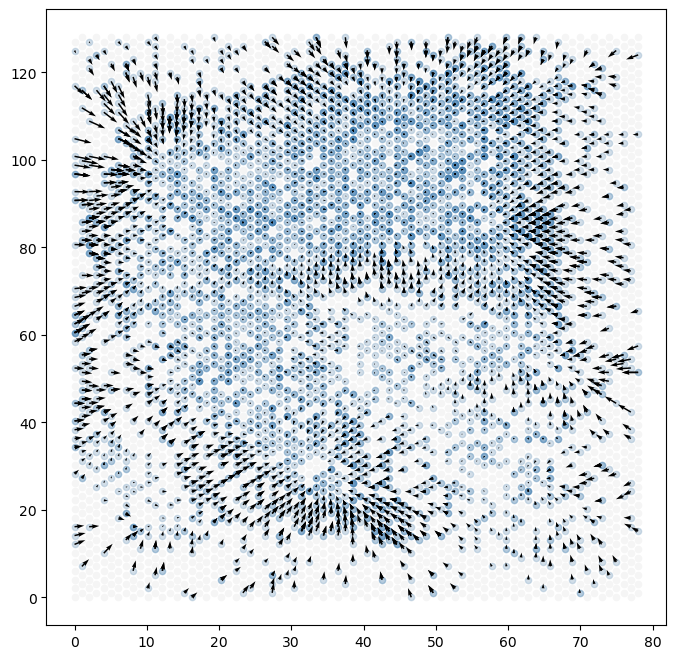

In [5]:
# --- Visualize the score function for a specific gene ---
# gene_index: which gene to plot (example: 4320)
# lam: regularization parameter (default 1.0)
# kernel_width: controls the neighborhood size used when estimating the score function (default 15.0)
# size: point size in the scatter plot (default 20)
# gradient_return=True: return the gradient values in addition to the plot
gradient = spadiff.scatter_plot(gene_index=4320, lam=1.0, kernel_width=15.0, size=20, gradient_return=True)

Notes

$\cdot$ The kernel_width determines how large a neighborhood is considered when estimating the gradient at each spatial position.

- Small kernel width → focuses on very local neighbors, may be noisy.

- Large kernel width → smoother estimate, but may oversmooth spatial details.

$\cdot$ The scatter plot of the score function helps users choose a proper kernel width by visually checking whether the gradients reflect realistic spatial structure.

$\cdot$ The default kernel_width=15.0 generally works well for most datasets, but users can tune it based on the visualization.

### 6. Visualize the Denoising Process

To check whether the denoising parameters are appropriate, SpaDiff can generate a GIF showing the step-by-step denoising of a single gene. This helps decide if the chosen values (e.g., *kernel_width*, *sigma*, *step_size*) properly recover the spatial structure.

In [6]:
# --- Visualize the denoising process for one gene ---
# gene_index: which gene to denoise (example: 4320)
# sigma: noise variance (default 0.1)
# kernel_width: neighborhood size for score estimation
# max_gradient: threshold to prevent extremely large gradient updates
# step_size: how far each denoising step moves points
# step: number of steps to show in the visualization
# generate_gif=True: output an animated GIF of the denoising trajectory
spadiff.denoise_single(gene_index=4320, sigma=0.1, kernel_width=15.0, max_gradient=5.0, step_size=0.5, size=20, step=10, generate_gif=True)

Notes

$\cdot$ The GIF shows how noisy spatial expression patterns gradually sharpen during denoising.

$\cdot$ If the denoising looks too slow or unstable, try adjusting step_size or max_gradient.

$\cdot$ If the final pattern appears oversmoothed or too noisy, tuning kernel_width or sigma can help.

$\cdot$ This step is mainly for diagnostics and parameter selection, not for large-scale denoising of all genes.

### 7. Denoise All Genes

After testing parameters on individual genes, we now apply SpaDiff’s main denoising function to all genes in the dataset. This step performs the reverse diffusion process across the entire expression matrix.

In [7]:
# --- Denoise the full dataset ---
# kernel_width: neighborhood size for score estimation
# sigma: noise variance
# step_size: step length for the reverse diffusion
# max_gradient: threshold to avoid excessively large updates
# step: number of denoising iterations
spadiff.denoise(kernel_width=15.0, sigma=0.1, step_size=0.2, max_gradient=5.0, step=10)

Pickling successful.
Starting parallel processing...
Created pool with 20 processes


100%|██████████| 4943/4943 [15:29<00:00,  5.32it/s]


Notes

$\cdot$ This is the main step of the method, applying denoising to all genes simultaneously.

$\cdot$ Parameters (*kernel_width*, *sigma*, *step_size*, *max_gradient*) can be adjusted based on the diagnostic plots/GIFs from earlier.

$\cdot$ The output is a denoised expression matrix, saved in the SpaDiff object, with clearer spatial patterns and preserved UMI counts.

### 8. Visualize Denoising Results

After running SpaDiff, we can compare gene expression patterns before and after denoising using scatter plots.

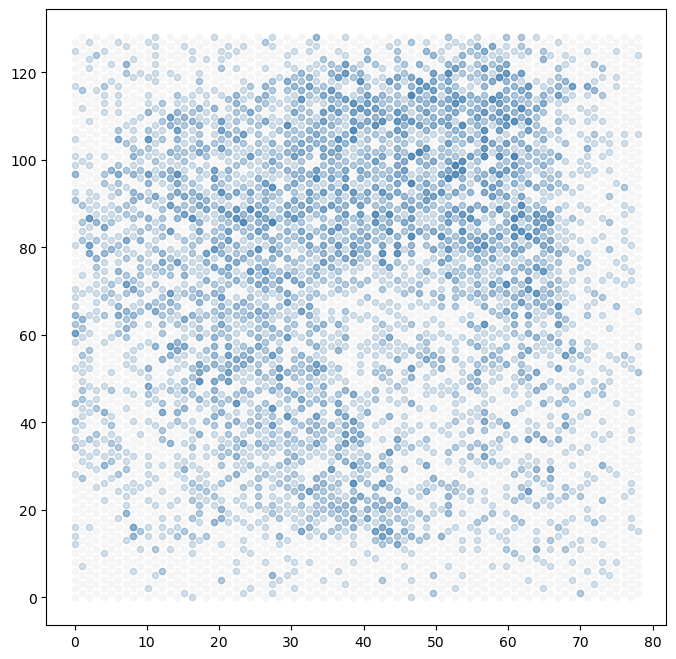

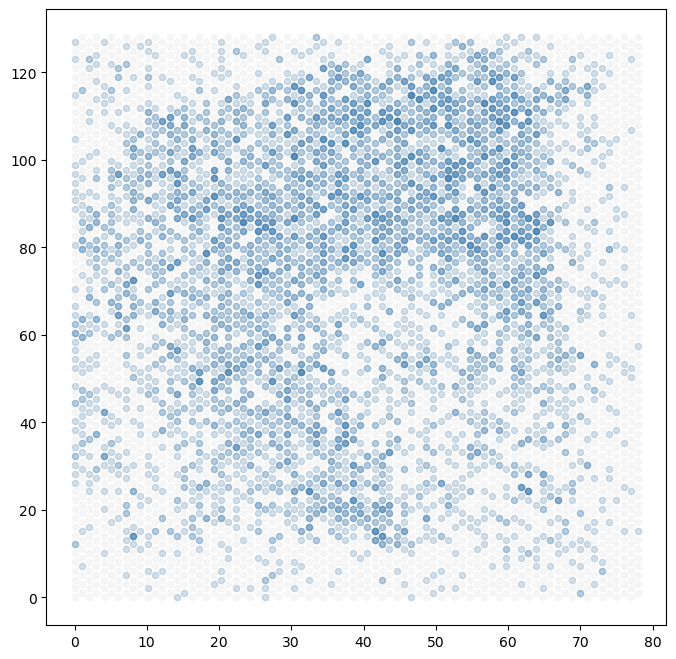

In [8]:
# --- Plot the raw expression pattern of a gene ---
spadiff.scatter_plot(gene_index=4320, size=20, gradient_plot=False)

# --- Plot the denoised expression pattern of the same gene ---
spadiff.scatter_plot(if_update=True, gene_index=4320, size=20, gradient_plot=False)

Notes

$\cdot$ The first plot shows the raw (noisy) expression pattern.

$\cdot$ The second plot shows the denoised expression pattern after applying SpaDiff (*if_update*=True).

$\cdot$ By comparing the two plots, users can visually assess how well SpaDiff has corrected spot-swapping and restored spatial structure.

### 9. Save Denoised Data

Finally, we extract the denoised expression matrix from the SpaDiff object and save it in the same format as the input files (Matrix Market + CSVs). This makes it easy to use the denoised data in other tools or pipelines.

In [ ]:
save_path = '/direction/to/save/the/data/' + tissue + '/denoised'
os.makedirs(save_path, exist_ok=True)

# --- Step 1: Extract denoised data ---
# Convert to sparse matrix in COO format for storage
matrix = sp.coo_matrix(spadiff.X_update.values.T)  # Convert to sparse COO format

# Extract barcodes (spots) and gene names
features = np.array(spadiff.X_update.columns, dtype=str)  # Cell barcodes
barcodes = np.array(spadiff.X_update.index, dtype=str)  # Gene names

# --- Step 2: Save expression matrix ---
mmwrite(f"{save_path}/matrix.mtx", matrix)

# --- Step 3: Save barcodes and gene names ---
pd.DataFrame(barcodes, columns=["Barcode"]).to_csv(f"{save_path}/barcodes.csv", index=False)
pd.DataFrame(features, columns=["Genes"]).to_csv(f"{save_path}/features.csv", index=False)

Notes

$\cdot$ The saved files (matrix.mtx, barcodes.csv, features.csv) follow the same format as the raw input data.

$\cdot$ This ensures compatibility with downstream tools (e.g., Seurat, Scanpy, or other spatial analysis pipelines).

$\cdot$ The denoised dataset can now directly replace the original raw count matrix for further analyses.